# Algorithmic Fairness: Considering Different Definitions

Approximate notebook time: 2 hours 

## Introduction

Decision making within the United States criminal justice system relies heavily on risk assessment, which determines the potential risk that a released defendant will fail to appear in court or cause harm to the public. Judges use these assessments to decide if bail can be set or if a defendant should be detained before trial. While this is not new in the legal system, the use of risk scores determined by an algorithm are gaining prevalence and support. Proponents promote the use of risk scores to guide judges in their decision making, arguing that machine learning could lead to greater efficiency, accountability, and less biased decisions compared with human judgment ([Henry](https://theappeal.org/risk-assessment-explained/)). On the other hand, critical voices raise the concern that biases can creep into these algorithms at any point in the process, and that algorithms are often applied to the wrong situations ([Henry](https://theappeal.org/risk-assessment-explained/)). Further, they exacerbate the racism embedded deep within the criminal justice system by perpetuating inequalities found in historical data ([Henry](https://theappeal.org/risk-assessment-explained/)).

In the debate about the use of risk assessment algorithms, people have used data analysis to determine the extent to which these algorithms are fair to different groups of people. In this homework, **you will explore some of the many definitions and metrics (different ways of operationalizing data to quantify those definitions) of fairness that can be applied to the risk assessment tool COMPAS**. In doing so, you will understand and provide evidence for or against the presence of bias within the algorithm. You will examine the arguments and analyses made by the company that created COMPAS and the critics of this risk assessment tool to gain a deeper understanding of the technical and societal interpretations and implications of fairness. 

**NOTE**: When we discuss bias in this module, we define it most generally as prejudice or an inclination in favor of one person, thing, or group compared to another. In the context of machine learning, bias is a “phenomenon that occurs when an algorithm produces results that are systemically prejudiced due to erroneous assumptions in the machine learning process” ([Rouse](https://searchenterpriseai.techtarget.com/definition/machine-learning-bias-algorithm-bias-or-AI-bias#:~:text=Machine%20learning%20bias%2C%20also%20sometimes,in%20the%20machine%20learning%20process)).

## Table of Contents:
* [Part 0. COMPAS](#part-zero)
* [Part 1. ProPublica's Perspective](#part-one)
* [Part 2. Northpointe's Perspective](#part-two)
* [Part 3. Another Definition of Fairness](#part-three)

## Setup

Let's begin by importing the packages we need.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
!pip install aif360
!pip install BlackBoxAuditing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[LFR]'
pip install 'aif360[AdversarialDebiasing]'


# Part 0. COMPAS: Why it was created and how it exists in the court system <a id="part-zero"></a>

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a commercial tool produced by the for-profit company Northpointe (acquired by equivant) known as a recidivism risk assessment system. **Tools like COMPAS are used to predict the risk of future crimes for an individual who has entered the US criminal justice system by outputting a risk score from 1-10**. While COMPAS was initially intended to aid decisions made by probation officers on treatment and supervision of those who are incarcerated, Northpointe has since emphasized the scalability of the tool to “fit the needs of many different decision points” including pre-screening assessments, pretrial release decisions (whether or not to hold an arrested individual in jail until their trial), and post-trial next steps for the defendant ([Northpointe](http://www.northpointeinc.com/files/downloads/FAQ_Document.pdf)). These algorithms are believed by many to provide the ability to make the court system more just by removing or correcting for bias of criminal justice officials.

### Question 0a
Explain 3 parties that are impacted by the COMPAS tool. In what ways are they impacted? (Can you think of impacts beyond those in the courtroom for at least one of your examples?)

*Student Written Answer Here*

### Question 0b
Based on your initial reading, what is one problem of the criminal justice system that the COMPAS tool could potentially alleviate? What is one potential problem that using the COMPAS algorithm could introduce? 

*Student Written Answer Here*

## Dataset Setup

We will be using the data that was obtained and used by ProPublica in their own analysis of the COMPAS tool from Broward County public records of people who were scored between 2013 and 2014 ([ProPublica](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)). In order to replicate ProPublica's analysis, we remove any cases where the charge was not within 30 days of the score (ProPublica did this in order to match the COMPAS score with the correct criminal case). We are left with 6172 rows in the dataset.

In [3]:
data = pd.read_csv('compas-scores-two-years.csv')
data = data.query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')
data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


We are also able to filter out any information that was not used by ProPublica and select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [4]:
select_data = data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
                    "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

### Question 0c
Explore the dataset. What is the granularity of this dataset? 

*Student Written Answer Here*

***Sensitive features*** are attributes within a dataset that are given special consideration and treatment for potential legal, social, or ethical reasons. Often, these features are recognized and protected by antidiscrimination or privacy laws. One example of a sensitive feature is age. 

### Question 0d
Identify 2 sensitive features in the dataset that we have not already mentioned. 

*Student Written Answer Here*

### Question 0e 
Pick one of the sensitive features you have identified. What features are proxies for that sensitive feature? 

*Student Written Answer Here*

### Question 0f
As a data scientist, why is it important to give special consideration to these kinds of features? 

*Student Written Answer Here*

# Part 1. ProPublica’s Perspective <a id="part-one"></a>

### Who is ProPublica?

ProPublica is a nonprofit organization that “produces investigative journalism with moral force” ([ProPublica](https://www.propublica.org/about/)). ProPublica was founded as a nonpartisan newsroom aiming to expose and question abuses of power, justice, and public trust, often by systems and institutions deeply ingrained in the US.

In 2016, ProPublica investigated the COMPAS algorithm to assess the accuracy of and potential racial bias within the tool, as it became more popular within the United States court system nationwide. In their analysis, ProPublica used data from defendants with risk scores from Broward County, FL from 2013 to 2014 to test for statistical differences in outcomes for Black and white defendants, which ultimately highlighted racial disparities that exist within the algorithm. ProPublica came to the conclusion that COMPAS utilizes data from a criminal justice system with a history of racial injustices, thus continuing to disproportionately target and arrest Black people in comparison to their white counterparts. While the COMPAS algorithm’s treats unequal groups alike, which may appear neutral, ProPublica’s data analysis and reporting emphasized the bias against Black defendants and their communities that COMPAS produced from this line of thinking, a claim that Northpointe has disputed (as we will see later).

Let's retrace ProPublica's statistical analysis in order to better understand ProPublica's argument and engage with the metric of fairness that it uses.

## Question 1. Logistic Regression: What are the odds of getting a high risk score?

ProPublica’s first attempt at understanding the disparity in risk scores from the COMPAS tool was through logistic regression to model the chance of getting a “higher” (i.e. more "risky") score. COMPAS labels scores 1-4 as low, 5-7 as medium, and 8-10 as high scores. For the purposes of their analysis, ProPublica labeled any score above a low score as high.

### Question 1a (i)
Create a logistic regression model to predict the score of defendants based on their sex, age, race, previous arrests, seriousness of the crime, and future criminal behavior. 

In [5]:
# Create independent variable decile score: 1 for "high" score, 0 for "low" score.
y = np.where(select_data.decile_score>4, 1, 0)


# Collect the dependent variables: Binarize categorical variables and take numerical variables from select_data.
# Numerical Variables
X = pd.DataFrame(select_data[["priors_count", "two_year_recid"]])

#Binarize sex, age categories, race, and charge degree
X["sex"] = pd.get_dummies(select_data["sex"])["Female"]
X[["Greater than 45", "Less than 25"]] = pd.get_dummies(select_data["age_cat"])[["Greater than 45", "Less than 25"]]
X[["African-American", "Asian", "Hispanic", "Native American", "Other"]] = pd.get_dummies(select_data["race"])[["African-American", "Asian", "Hispanic", "Native American", "Other"]]
X["misdemeanor_charge"] = pd.get_dummies(select_data["c_charge_degree"])["M"]


# Create the model 
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

### Question 1a (ii)
Print out the coefficients paired with the corresponding feature names.

In [6]:
# Pair the coefficients with feature names
features = list(X.columns)
print(list(zip(features, model.coef_[0])))

[('priors_count', 0.26841574060888973), ('two_year_recid', 0.6831840383941473), ('sex', 0.21881440417074133), ('Greater than 45', -1.345344452434324), ('Less than 25', 1.3015017693515076), ('African-American', 0.47767854348036104), ('Asian', -0.20805671230713116), ('Hispanic', -0.42133030966487106), ('Native American', 0.8956289051113875), ('Other', -0.8059219576573431), ('misdemeanor_charge', -0.3098895148947778)]


### Question 1b
What features are most predictive? 

*Student Written Answer Here*

### Question 1c
Are Black defendants more likely to get a high risk score opposed to white defendants? If so, by how much? Show your calculations. 

In [7]:
intercept = model.intercept_[0]
control = np.exp(intercept)/(1 + np.exp(intercept))
black_coef = model.coef_[0][5]
np.exp(black_coef)/(1 - control + (control * np.exp(black_coef)))

1.4530844528826197

*Student Written Answer Here* 

## Question 2. FPR and FNR: Does COMPAS overpredict or underpredict across groups?

In order to answer this question and understand the ways in which bias is present in the risk scores, ProPublica used the False Positive Rate (FPR) and False Negative Rate (FNR) as their metrics to understand and quantify fairness. 

### Question 2a
Complete the following functions to calculate the FPR and FNR. Afterwards, apply these functions to each racial subgroup: Black defendants and white defendants. Keep in mind that ProPublica defines a high score as anything above 4, and therefore a false positive would be a defendant with a high score who did not recidivate. 

In [7]:
def fpr(race_feature, data):
    # Return the False Positive Rate of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    did_not_recidivate = subgroup[subgroup["two_year_recid"] == 0]

    fp = did_not_recidivate[did_not_recidivate["decile_score"] > 4].shape[0]
    tn = did_not_recidivate[did_not_recidivate["decile_score"] <= 4].shape[0]
    return fp / (fp + tn)


def fnr(race_feature, data):
    # Return the False Negative Rate of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    recidivated = subgroup[subgroup["two_year_recid"] == 1]
    
    fn = recidivated[recidivated["decile_score"] <= 4].shape[0]
    tp = recidivated[recidivated["decile_score"] > 4].shape[0]
    return fn / (fn + tp)


In [8]:
# Apply the metrics to the dataset
print("FPR for Black defendants:", fpr("African-American", select_data))
print("FPR for white defendants:", fpr("Caucasian", select_data))
print("FNR for Black defendants:", fnr("African-American", select_data))
print("FNR for white defendants:", fnr("Caucasian", select_data))

FPR for Black defendants: 0.4233817701453104
FPR for white defendants: 0.22014051522248243
FNR for Black defendants: 0.2847682119205298
FNR for white defendants: 0.49635036496350365


### Question 2b
What can you conclude from these metrics about the overprediction of risk scores for Black and white defendants? By how much is the tool overpredicting?  (Hint: Look at your calculations for the FPR.)

In [9]:
# Calculation of ratio for FPR
fpr("African-American", select_data) / fpr("Caucasian", select_data)

1.9232342111919953

*Student Written Answer Here*

### Question 2c
What can you conclude from these metrics about the underprediction of risk scores for Black and white defendants? By how much is the tool underpredicting? (Hint: Look at your calculations for the FNR.)

In [10]:
# Calculation of ratio for FNR
fnr("Caucasian", select_data) / fnr("African-American", select_data)

1.7429977932439313

*Student Written Answer Here*

### Question 2d
What is the importance of overprediction and underprediction in regard to ProPublica’s analysis? How might these observations have real impacts on the defendants who receive scores?

*Student Written Answer Here*

##  Question 3.

### Question 3a (i)
Utilizing your answers from 1b and 2b, what problems does ProPublica highlight in the COMPAS algorithm? 

*Student Written Answer Here*

### Question 3a (ii)
How would you describe ProPublica’s definition of fairness, after learning and utilizing the metrics they used?

*Student Written Answer Here*

### Question 3b 
Why did ProPublica choose to investigate bias between races rather than a different sensitive feature? (Hint: think about how ProPublica’s conclusions reflect the racial disparities in our current criminal justice system.)

*Student Written Answer Here*

### Question 3c
What is ProPublica’s agenda as an investigative journalism organization? How do we see this in their analysis and conclusions?

*Student Written Answer Here*

We mentioned earlier that Northpointe disagreed with ProPublica's argument that the COMPAS algorithm is racially biased. Now that we’ve analyzed ProPublica’s perspective and seen the way in which they define and operationalize the concept of fairness, let’s move on to Northpointe’s.

# Part 2. Northpointe's Perspective <a id="part-two"></a>

### Who is Northpointe? 

Northpointe (merged with two other companies to create *equivant* in 2017) is a for-profit computer software company that aims to advance justice by informing and instilling confidence in decision makers at every stage of the criminal justice system ([equivant](https://www.equivant.com/)). In addition to operating and continuing to develop COMPAS, *equivant* has developed a variety of technologies for use in court case management, attorney case management, inmate classification, and risk/needs assessment strategies. 

In the wake of criticism from ProPublica and other researchers alike, Northpointe produced a [detailed response](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf) to ProPublica’s allegations, claiming that these critiques of their tool utilized the wrong type of classification statistics in their analysis and portrayed the tool incorrectly. The company provided their own analysis of the COMPAS algorithm by using different statistical methods and responding individually to each of ProPublica’s claims of racial bias against Black defendants. 

Upon examining their tool’s fairness through accuracy equity and predictive parity (which are metrics that were left out of ProPublica’s analysis), as well as the fact that the model was not trained with a race feature, Northpointe concluded that their algorithm treats all citizens and specified groups equally, and therefore does not exhibit signs of bias or inequality for specified groups. Now, let’s take a look at how Northpointe supported this argument.

## Question 4. Accuracy Equity: Is each group being discriminated against equally?

Instead of analyzing and comparing the model errors FNR and FPR, Northpointe utilized the complement of FNR, known as the TPR (or what is often referred to as *Sensitivity*), paired with the FPR to prove what they refer to as ***Accuracy Equity*** through the use of a *ROC Curve*. Accuracy equity, according to [Northpointe](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf), is exhibited in the model “if it can discriminate recidivists and nonrecidivists equally well for two different groups such as blacks and whites.” Recall that we use ROC curves and the *Area Under the Curve* to understand how much a model is capable of distinguishing between classes. 

### Question 4a
Utilize the sklearn metrics package to calculate TPR and FPR, visualize the ROC curve for both white and Black defendants, and calculate the AUC for each curve.

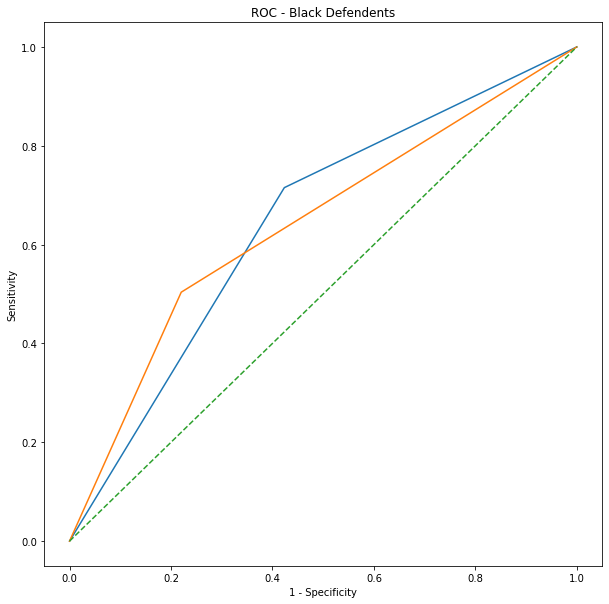

In [8]:
# Calculate FPR and FNR from metrics package - Black defendants
black_def = select_data[select_data["race"] == "African-American"]
# True binary values
y1 = black_def['two_year_recid']
# Predicted values from COMPAS tool
pred1 = black_def["decile_score"].replace([1, 2, 3, 4], 0).replace([5, 6, 7, 8, 9, 10], 1)
fpr_black, tpr_black, threshold = roc_curve(y1, pred1)

# Calculate FPR and FNR from metrics package - White defendants
white_def = select_data[select_data["race"] == "Caucasian"]
# True binary values
y2 = white_def['two_year_recid']
# Predicted values from COMPAS tool
pred2 = white_def["decile_score"].replace([1, 2, 3, 4], 0).replace([5, 6, 7, 8, 9, 10], 1)
fpr_white, tpr_white, threshold = roc_curve(y2, pred2)

# Plot the ROC 
plt.subplots(1, figsize=(10,10))
plt.title('ROC - Black Defendents')
plt.plot(fpr_black, tpr_black)
plt.plot(fpr_white, tpr_white)
plt.plot([0, 1], ls="--")
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
plt.show()


In [14]:
# Calculate the AUC
print("AUC for Black defendants:", roc_auc_score(y1, pred1))
print("AUC for white defendants:", roc_auc_score(y2, pred2))

AUC for Black defendants: 0.6459250089670798
AUC for white defendants: 0.641754559907007


### Question 4b (i)
What do you notice from the ROC curve and the AUC calculation? List at least two general observations. 

*Student Written Answer Here*

### Question 4b (ii)
What could Northpointe take away from this visualization to prove their point? Is accuracy equity being represented here? (Hint: Is each racial group being discriminated against equally?)

*Student Written Answer Here*

## Question 5. Predictive Parity: Is the likelihood of recidivism equal across groups?

In addition to the metric outlined above, Northpointe also utilized positive predictive values to explore the likelihood of defendants to reoffend, and to therefore prove that ***Predictive Parity*** is achieved. Predictive parity, according to [Northpointe](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf), is exhibited in a model “if the classifier obtains similar predictive values for two different groups such as blacks and whites, for example, the probability of recidivating, given a high risk score, is similar for blacks and whites.” Let’s explore how they analyzed this. 

### Question 5a 

Complete the following functions to calculate the positive predictive values and negative predictive values. Afterwards, apply these functions to the data of white defendants and the data of Black defendants. 

In [15]:
def ppv(race_feature, data):
    # Return the Positive Predictive Value of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    recidivated = subgroup[subgroup["two_year_recid"] == 1]
    did_not_recidivate = subgroup[subgroup["two_year_recid"] == 0]
    
    fp = did_not_recidivate[did_not_recidivate["decile_score"] > 4].shape[0]
    tp = recidivated[recidivated["decile_score"] > 4].shape[0]
    return tp / (tp + fp)


def npv(race_feature, data):
    # Return the Negative Predictive Value of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    recidivated = subgroup[subgroup["two_year_recid"] == 1]
    did_not_recidivate = subgroup[subgroup["two_year_recid"] == 0]

    fn = recidivated[recidivated["decile_score"] <= 4].shape[0]
    tn = did_not_recidivate[did_not_recidivate["decile_score"] <= 4].shape[0]
    return tn / (tn + fn)


In [16]:
# Apply metrics to the dataset
print("PPV for Black defendants:", ppv("African-American", select_data))
print("NPV for Black defendants:", npv("African-American", select_data))
print("PPV for white defendants:", ppv("Caucasian", select_data))
print("NPV for white defendants:", npv("Caucasian", select_data))

PPV for Black defendants: 0.6495352651722253
NPV for Black defendants: 0.6485884101040119
PPV for white defendants: 0.5948275862068966
NPV for white defendants: 0.7100213219616205


### Question 5b
Use the metrics you calculated above to fill in the table below.

| |  White  | Black    |
|---:|:-------------|:-----------|
| Labeled higher risk, but didn't reoffend | 41% | 35% |
| Labeled lower risk, but did reoffend | 29% | 35% |

In [17]:
# High risk but did not re-offend - white
1 - ppv("Caucasian", select_data)
# Low risk but did re-offend - white
1 - npv("Caucasian", select_data)
# High risk but did not re-offend - Black
1 - ppv("African-American", select_data)
# Low risk but did re-offend - Black
1 - npv("African-American", select_data)

0.3514115898959881

### Question 5c (i)
What do you notice about the positive predictive values for each group? List at least one general observation.

*Student Written Answer Here*

### Question 5c (ii)
What could Northpointe conclude from these findings? Is predictive parity represented here? (Hint: Is the likelihood of recidivism relatively equal for each racial group?)

*Student Written Answer Here*

## Question 6.

### Question 6a
How would you describe Northpointe’s definition of fairness, after learning and utilizing the metrics they used? How is this different from your description of ProPublica’s definition from Q3aii? 

*Student Written Answer Here*

### Question 6b 

If anything, what are ProPublica and Northpointe each not considering in their definitions? (Hint: Think about other goodness metrics in ML, as well as your knowledge of the historical context of policing data)

*Student Written Answer Here*

So far, we’ve investigated ProPublica’s and Northpointe’s definitions of fairness. In the world of machine learning there are [many more](https://www.google.com/url?q=https://fairmlbook.org/tutorial2.html&sa=D&ust=1606727018134000&usg=AOvVaw06zU_fm8h7xp71d8igA8KI), so in the next section we will take a look at a third definition.

# Part 3. Yet Another Definition of Fairness <a id="part-three"></a>

In this section, you will go through yet another metric and definition used to evaluate fairness in machine learning: **disparate impact**. Disparate impact is a legal doctrine that determines if there is unintended discrimination towards a protected class ([Society for Human Resource Management](https://www.shrm.org/resourcesandtools/tools-and-samples/hr-qa/pages/disparateimpactdisparatetreatment.aspx)). In machine learning, disparate impact is a metric to evaluate fairness in a model. It is a form of bias within an algorithm that reflects systemic discrimination when a model’s outputs are dependent on a ***sensitive feautre*** (the protected class). This is often considered unintentional (like the legal doctrine) due to the fact that the sensitive feature is omitted from the model, though it is still correlated with the output through proxy variables ([Wang et al.](https://arxiv.org/pdf/1801.05398.pdf#:~:text=Abstract%E2%80%94In%20the%20context%20of,e.g.%2C%20race%20or%20gender)).

Not only will you evaluate the fairness of the tool (as Northpointe and ProPublica did) by measuring the bias reflected in the outputs of the model, but you will remove it to actually change those outputs and therefore eliminate the dependencies between the risk scores and the race feature. In order to computationally remove the disparate impact that we quantify, we can use tools like aif360’s [Disparate Impact Remover](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html). aif360 is a package created by IBM’s AI Research team, which contains a variety of tools to “help you examine, report, and mitigate discrimination and bias in machine learning models throughout the AI application lifecycle” ([AI Fairness 360](https://aif360.mybluemix.net/)).

## Question 7. Disparate Impact: Quantification and Removal

First, let’s visualize the disparity that we would like to remove from the dataset. In order to do that we need to distinguish between a privileged group and an unprivileged group. In technical terms, the privileged group receives higher scores from a trained model, so therefore the Black defendants will be considered "privileged" and the white defendants will be considered "unprivileged" in this case. 

### Question 7a

Use a histogram to plot the scores for Black defendants and the scores for white defendants. Visualize both histograms on the same plot.

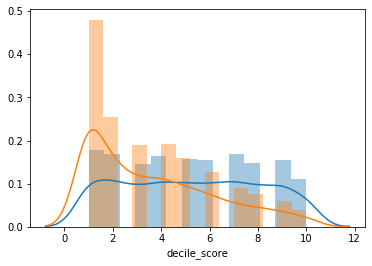

In [62]:
unpriv = select_data[select_data["race"] == "Caucasian"]
priv = select_data[select_data["race"] == "African-American"]
sns.distplot(priv["decile_score"], hist=True, rug=False)
sns.distplot(unpriv["decile_score"], hist=True, rug=False)

### Question 7b 

What do you notice from the plot? (Hint: how do the distributions differ across racial groups with respect to mean, shape of distribution, etc.) 

*Student Written Answer Here*

Now, we need to quantify the disparate impact we are seeing in the plot. In machine learning, we can understand disparate impact as the proportion of individuals that get positive outcomes (did they get a high score) for the two groups described above:

\begin{align}
\Pr(Y=1|D=Unprivileged) \ / \ \Pr(Y=1|D=Privileged)
\end{align}

In this equation Y is 1 if the defendant received a high score and 0 if they received a low score. 

### Question 7c (i)

Create a function to calculate the proportion of individuals from a specified racial group that get positive outcomes.

In [56]:
def proportion(data, group):
    # Returns the proportion of individuals in data from the group who recidivate
    race_group = data[data["race"] == group]
    positive_outcomes = race_group[race_group["decile_score"] > 4]
    return len(positive_outcomes) / len(race_group)

### Question 7c (ii)

Use this function to calculate the disparate impact, using the equation from above.

In [57]:
prob_priv = proportion(select_data, "African-American")
prob_unpriv = proportion(select_data, "Caucasian")
prob_unpriv / prob_priv

0.5745131730114521

If the proportion of unprivileged individuals receiving positive outcomes to privileged individuals receiving positive outcomes is less than 80%, there is a disparate impact violation. In order to stop a trained model from replicating these biases in its output, we can now use aif360’s Disparate Impact Remover to remove the bias we just calculated.

### Question 7d

Create a Disparate Impact Remover type object and use the function fit_transform on our data. In order to do this you will need to first create a BinaryLabelDataset from our dataset to use for fit_transform. Check out the documentation [here](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset) to see how to implement this.

In [58]:
# Create new DataFrame with just the necessary columns - Only numeric values for race, decile score, and two year recid

# The BinaryLabelDataset requires decile_scores to be continuous -->
# Use this line of code noise = np.random.normal(0, 0.1, race_data.shape[0]) to add noise to your decile_score column

race_data = select_data[(select_data["race"] == "Caucasian") | (select_data["race"] == "African-American")]
race_col = pd.get_dummies(race_data, "race")["race_Caucasian"]
noise = np.random.normal(0, 0.1, race_data.shape[0])
decile_col = race_data["decile_score"] + noise
recid_col = race_data["two_year_recid"]
new_df = pd.DataFrame({"race": race_col, "decile_score": decile_col, "two_year_recid": recid_col})

# Create BinaryLabelDataset
BLD = BinaryLabelDataset(favorable_label=1, # Positive Outcome
                         unfavorable_label=0, # Negative Outcome
                         df=new_df,
                         label_names=["two_year_recid"],
                         protected_attribute_names=["race"],
                         unprivileged_protected_attributes=[1])

In [59]:
remover = DisparateImpactRemover(repair_level=1.0, sensitive_attribute="race")
transformed_data = remover.fit_transform(BLD)

### Question 7e

Similar to part a, use a histogram to plot the scores on the modified dataset. Afterwards, use the proportion function created above to calculate the disparate impact of the transformed dataset.

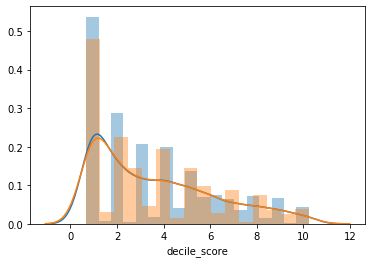

In [60]:
# Transform output from DIRemover into usable DataFrame
transformed_df = pd.DataFrame(np.hstack([transformed_data.features, transformed_data.labels]),
                              columns=["race","decile_score","two_year_recid"])

unpriv_t = transformed_df[transformed_df["race"] == 1]
priv_t = transformed_df[transformed_df["race"] == 0]
sns.distplot(priv_t["decile_score"], hist=True, rug=False)
sns.distplot(unpriv_t["decile_score"], hist=True, rug=False)

In [61]:
# Calculate disparate impact
prob_priv_t = proportion(transformed_df, 0)
prob_unpriv_t = proportion(transformed_df, 1)
prob_unpriv_t / prob_priv_t

0.9996653950920561

### Question 7f

What has changed from our original histogram? Please explain why this change has happened. 

*Student Written Answer Here*

### Question 7g

How might we understand this definition of fairness, after learning and utilizing these metrics? 

*Student Written Answer Here*

### Question 7h
How does this definition of fairness differ from ProPublica’s and Northpointe’s? 

*Student Written Answer Here*

## Question 8. Considering Expertise Outside of Data Science

Just now, you used your technical data science skills to computationally remove bias from the data set. By removing bias, we’ve made the outputs of the algorithm statistically fair in regards to one definition of fairness. However, it is important to consider many types of knowledge and experiences beyond data science expertise when analyzing and creating an algorithm like COMPAS. As such, you will think through issues of expertise and fairness in the next set of questions.

### Question 8a

Look back to your answer from Q0a. Now that you’ve gone through several definitions of fairness, how would you add to or revise your answer: Explain 3 parties that are impacted by the COMPAS tool. In what ways are they impacted?

*Student Written Answer Here*

### Question 8b

What expertise and lived experiences are necessary to understand and critically think about the issues produced by COMPAS?

*Student Written Answer Here*

### Question 8c

Why is this third definition of fairness still inadequate as a measurement of justice in the court system? (Hint: look at the previous two questions and answers).

*Student Written Answer Here*

 # Part 4. Conclusion

## Question 9. Which Definition Is Fair? And Who Decides?

We’ve now gone through three definitions of fairness, each one with a different idea of how to operationalize fairness and to judge whether or not an algorithm is fair. As a data scientist, you may encounter situations where you will need to make decisions that affect real-world outcomes and people! Let’s try to do this for COMPAS. 

### Question 9a
If you had to decide between three definitions of fairness above, which definition do you think would make “fair” decisions for everyone who goes through the court system? What values did you consider as you made this decision? If you cannot come to a decision, what challenges did you come across when considering this? 

*Student Written Answer Here*

### Question 9b
Take a step back and think about how different actors who created, utilize, and are affected by COMPAS would consider which definition is most fair. Name two relevant actors, and discuss what they would value in *their own* definitions of fairness. Of the three definitions you have explored, which would they decide is most fair from the perspective of that actor? If you don’t think they’d choose any of them, explain why. (Examples of actors, which you’re welcome to use: judges, defendants, police, policy makers, community members) 

*Student Written Answer Here*

Choosing one definition of fairness can be incredibly difficult when you need to consider all the actors at play. Throughout this module we have examined where and how the COMPAS algorithm is appropriate to use. It is also important to recognize the problems that are not solvable by an algorithm and think through how we can make the ecosystem that COMPAS is in  (which includes but is not limited to the legal system, affected communities, the tech industry, etc.) more equitable.

### Question 9c
What issues that are relevant to the COMPAS ecosystem but outside of the algorithm itself need to be addressed to be able to create a more equitable system, with or without the algorithm? 

*Student Written Answer Here*

You’ve now begun to think through the very complex systems in which the COMPAS algorithm functions. **Congratulations!** Through considering a few of the differing definitions of fairness connected to COMPAS, hopefully you can begin to understand some of the human contexts of  creating algorithms that intentionally affect people and their decision-making. 